#Fashion-MNIST Giyim Eşyası Sınıflandırma Projesi

Bu projede, Fashion-MNIST veri seti üzerinde derin öğrenme tabanlı bir giyim eşyası sınıflandırma modeli geliştiriyorum. Modelin mimarisi, hiperparametre seçimleri ve sonuçlar detaylı şekilde açıklanmıştır.

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## 1. Giriş ve Veri Seti Yükleme

Fashion-MNIST veri seti, 28x28 boyutunda gri tonlamalı 70.000 adet giyim eşyası görselini içerir. Her görsel, toplam 10 farklı kategoriye (örneğin tişört, pantolon, kazak vb.) ait bir etikete sahiptir.

In [251]:
# Veri setini yükleme
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


## 2. Veri Keşfi ve Görselleştirme

Veri setinin boyutlarını inceleyerek ve örnek görselleri görselleştirerek başlıyoruz.

In [252]:
print("Eğitim görselleri boyutu:", train_images.shape)
print("Eğitim etiketleri boyutu:", train_labels.shape)
print("Test görselleri boyutu:", test_images.shape)
print("Test etiketleri boyutu:", test_labels.shape)

Eğitim görselleri boyutu: (60000, 28, 28)
Eğitim etiketleri boyutu: (60000,)
Test görselleri boyutu: (10000, 28, 28)
Test etiketleri boyutu: (10000,)


In [253]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

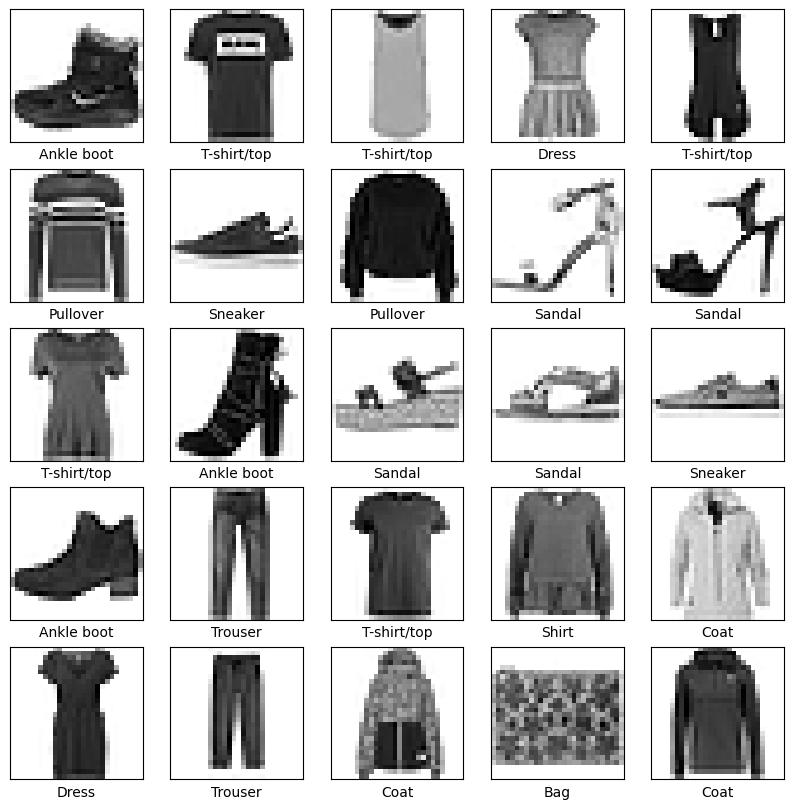

In [254]:
# Örnek 25 görseli görselleştirme
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 3. Veri Ön İşleme

Modelimiz için veriyi uygun forma getiriyoruz:
- Görselleri 28x28'den 784 boyutlu vektöre dönüştürme
- Piksel değerlerini [0,255] aralığından [0,1] aralığına normalize etme
- Etiketleri one-hot encoding formatına çevirme

In [255]:
# Veri ön işleme
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = train_images.astype('float32') / 255.0

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, num_classes = 10)
test_labels = to_categorical(test_labels, num_classes=10)

## 4. Model Mimarisi
Modelimiz, evrişimli sinir ağı (CNN) kullanan çok katmanlı bir derin öğrenme mimarisidir:

1. **Conv2D Katmanı 1**: 32 filtre, 3x3 çekirdek boyutu, ReLU aktivasyonu

2. **BatchNormalization Katmanı 1**: Aktivasyon sonrası veriyi normalize eder

3. **Conv2D Katmanı 2**: 32 filtre, 3x3 çekirdek boyutu, ReLU aktivasyonu

4. **BatchNormalization Katmanı 2**: Aktivasyon sonrası veriyi normalize eder

5. **MaxPooling2D Katmanı 1**: 2x2 havuzlama

6. **Dropout Katmanı 1**: %25 oranında dropout

7. **Conv2D Katmanı 3**: 64 filtre, 3x3 çekirdek boyutu, ReLU aktivasyonu

8. **BatchNormalization Katmanı 3**: Aktivasyon sonrası veriyi normalize eder

9. **Conv2D Katmanı **4: 64 filtre, 3x3 çekirdek boyutu, ReLU aktivasyonu

10. **BatchNormalization Katmanı 4**: Aktivasyon sonrası veriyi normalize eder

11. **MaxPooling2D Katmanı 2**: 2x2 havuzlama

12. **Dropout Katmanı 2**: %25 oranında dropout

13. **Flatten Katmanı**: Özellik haritalarını düzleştirerek tam bağlantılı katmana aktarır

14. **Gizli Katman**: 256 nöronlu, ReLU aktivasyonu, BatchNormalization ve %50 Dropout

15. **Çıkış Katmanı**: 10 nöronlu (sınıf sayısı), Softmax aktivasyonu

### Katman Seçimlerinin Gerekçeleri:
- **Conv2D Katmanları**:

  - Görsel verilerde öznitelik çıkarımı için idealdir.

  - 3x3 filtreler, yerel desenleri tanımada yaygın ve etkilidir.

  - Filtre sayısı 32 → 64 şeklinde artırılarak modelin öğrenme kapasitesi genişletilmiştir.

- **BatchNormalization Katmanları**:

  - Eğitim sürecini hızlandırır, ağırlıkların daha dengeli güncellenmesini sağlar.

  - Aktivasyon çıktılarının dağılımını normalize ederek öğrenmeyi kolaylaştırır.

- **MaxPooling2D Katmanları**:

  - Boyutları küçültür, hesaplama yükünü azaltır.

  - Önemli özellikleri korurken uzamsal boyutu azaltır.

- **Dropout Katmanları**:

  - Aşırı öğrenmeyi engeller, modelin genelleme yeteneğini artırır.

  - %25 ve %50 oranları, farklı seviyelerde düzenleme sağlar.

- **ReLU Aktivasyonu**:

  - Hesaplama açısından verimli ve gradyan kaybı problemini azaltır.

  - Özellikle görsel verilerde yaygın olarak tercih edilir.

- **Flatten Katmanı**:

  - 2D özellik haritalarını 1D vektöre dönüştürerek tam bağlantılı katmanlara geçiş sağlar.

- **256 Nöronlu Gizli Katman**:

  - Karmaşık ilişkileri öğrenmek için yeterli kapasite sağlar.

  - ReLU aktivasyonu ve dropout ile desteklenmiştir.

- **Softmax Çıkış Katmanı**:

  - çok sınıflı sınıflandırma problemi için uygundur.

  - Çıkışları olasılık dağılımına dönüştürerek sınıf tahmini sağlar.

In [257]:
# Model oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


# Model özeti
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,426 (3.33 MB)

 Trainable params: 871,530 (3.32 MB)

 Non-trainable params: 896 (3.50 KB)

## 5. Model Derleme

Modeli Adam ile derliyoruz.

### Optimizasyon Seçimleri:

- **Optimizer**: Adam
  - RMSprop ve Momentum’un birleşimi olarak düşünülebilir

  - Öğrenme oranını her parametre için dinamik olarak ayarlar

  - Gürültülü gradyanlarda bile kararlı öğrenme sağlar

  - Görüntü sınıflandırma gibi derin öğrenme problemlerinde sıkça tercih edilir

- **Loss Fonksiyonu**: Categorical Crossentropy
  - Çok sınıflı sınıflandırma için uygun
  - Model çıktıları ile gerçek etiketler arasındaki farkı ölçer

- **Metrik**: Accuracy
  - Basit ve yorumlanması kolay bir metrik
  - Doğru sınıflandırma oranını gösterir

In [258]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 6. Model Eğitimi
Modeli 40 epoch’a kadar, 64’lük batch size ile eğitiyoruz.

### Eğitim Parametreleri:
- **Epoch Sayısı = 40**:

  - Eğitim, maksimum 40 epoch sürebilir ancak early stopping sayesinde bu sayıya ulaşmadan da durabilir

- **patience = 5**:

  - Doğrulama kaybı 5 ardışık epoch boyunca iyileşmezse eğitim durdurulur

  - Bu sayede gereksiz yere uzun süren eğitimlerin önüne geçilir

- **restore_best_weights = True**:

  - Eğitim sonunda, en iyi doğrulama performansının elde edildiği epoch’taki ağırlıklar geri yüklenir

- **Batch Size = 64**:

  - 64 örneklik mini-batch’ler, modelin bellek verimliliğini korurken dengeli öğrenmesini sağlar

  - 32–128 aralığı arasında ideal kabul edilen batch boyutlarından biridir



- **Validation Split = 0.2**:

  - Eğitim verisinin %20'sini doğrulama için ayırıyoruz
  - Modelin genelleme performansını gözlemlemek için

- **EarlyStopping Callback**:

  - Eğitim süresini kısaltmak ve aşırı uyumu önlemek için kullanılır

  - Eğitim doğrulama kaybına göre dinamik olarak sonlandırılır

In [259]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    epochs=40,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7756 - loss: 0.6854 - val_accuracy: 0.8907 - val_loss: 0.3107
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8829 - loss: 0.3237 - val_accuracy: 0.9014 - val_loss: 0.2670
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9019 - loss: 0.2752 - val_accuracy: 0.9093 - val_loss: 0.2499
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9118 - loss: 0.2426 - val_accuracy: 0.9118 - val_loss: 0.2395
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9181 - loss: 0.2273 - val_accuracy: 0.9247 - val_loss: 0.2121
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9235 - loss: 0.2102 - val_accuracy: 0.9186 - val_loss: 0.2207
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9274 - loss: 0.2027 - val_accuracy: 0.9276 - val_loss: 0.1991
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9341 - loss: 0.1818 - val_accuracy:

## 7. Model Değerlendirme

Eğitilen modeli test seti üzerinde değerlendiriyoruz.

In [260]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest doğruluğu: {test_acc:.4f}')
print(f"Test kaybı: {test_loss:.4f}")

313/313 - 1s - 3ms/step - accuracy: 0.9326 - loss: 0.2004

Test doğruluğu: 0.9326
Test kaybı: 0.2004


## 8. Eğitim Süreci Görselleştirme

Eğitim ve doğrulama metriklerini görselleştirerek modelin öğrenme sürecini analiz ediyoruz.

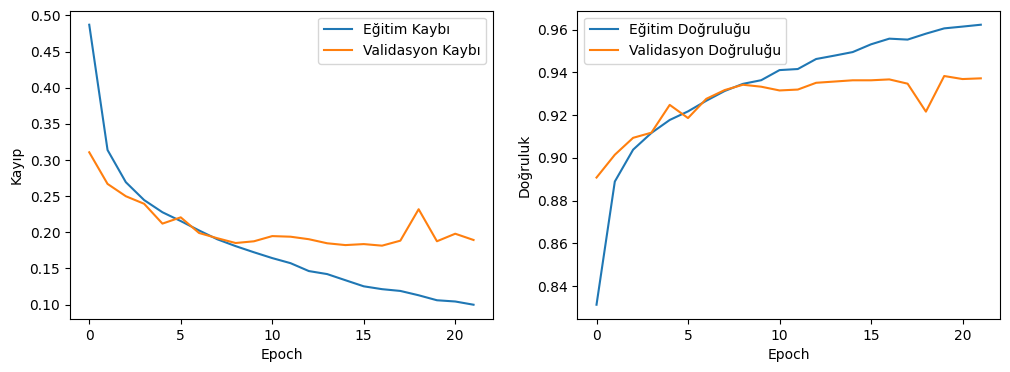

In [261]:
# Eğitim ve validasyon kaybını görselleştirme
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Validasyon Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Eğitim ve validasyon doğruluğunu görselleştirme
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validasyon Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

## 9. Tahminler ve Sonuçlar

Modelin test setindeki bazı örnekler üzerindeki tahminlerini görselleştiriyoruz. Doğru tahminler yeşil, yanlış tahminler kırmızı ile gösterilmiştir.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


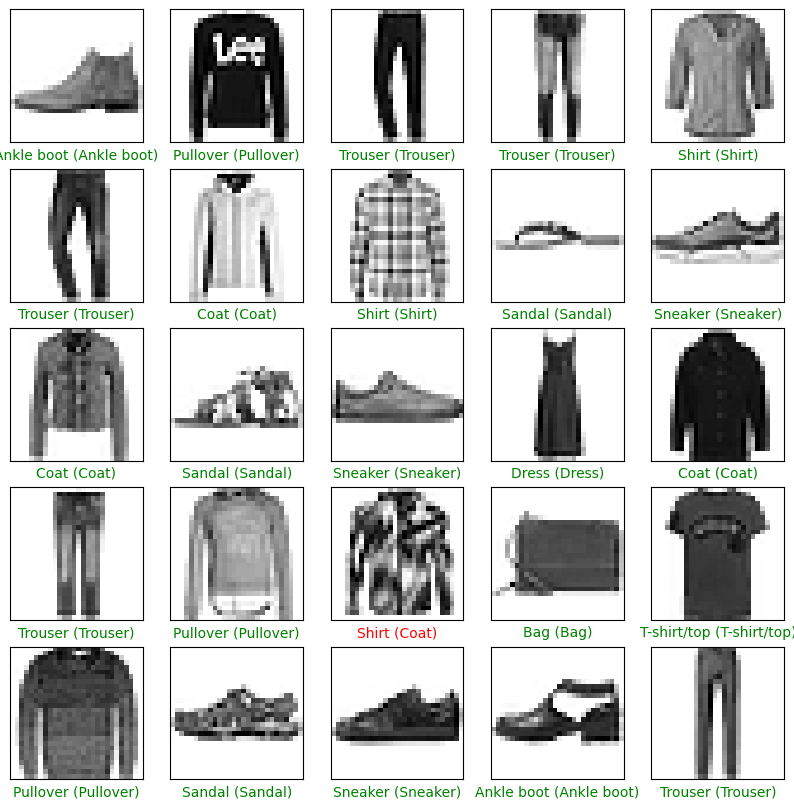

In [262]:
predictions = model.predict(test_images)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].reshape(28,28), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions[i])
    true_label = np.argmax(test_labels[i])

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)
plt.show()

## 10. Karışıklık Matrisi ve Detaylı Performans Analizi

Modelin sınıflandırma performansını daha detaylı analiz etmek için bir karışıklık matrisi oluşturuyoruz. Bu bize hangi sınıfların birbirleriyle karıştırıldığını gösterecek.

In [263]:
# Tahminleri ve gerçek etiketleri hazırlama
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

In [264]:
# Karışıklık matrisi hesaplama
cm = confusion_matrix(y_true, y_pred)

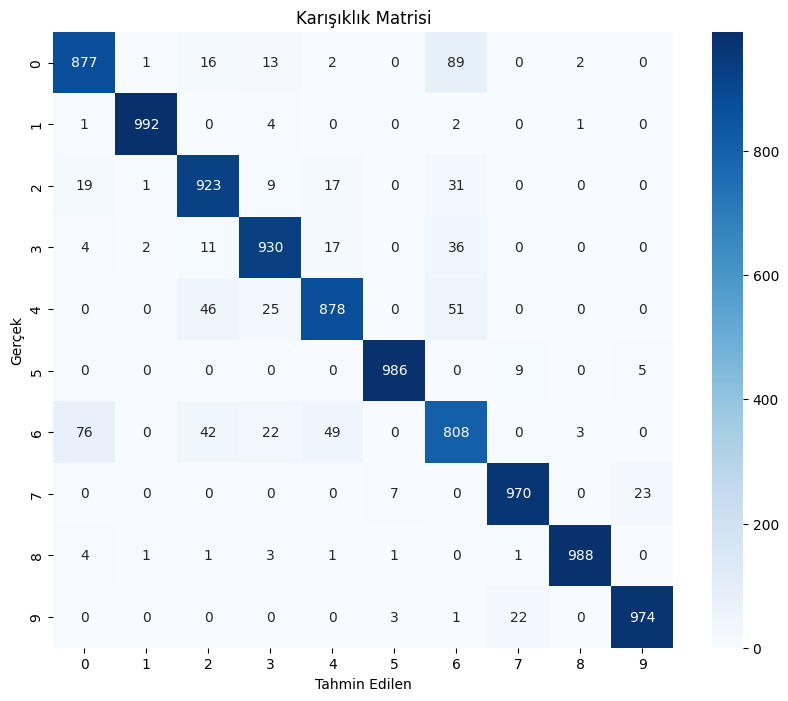

In [265]:
# Karışıklık matrisi görselleştirme
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

In [266]:
# Sınıflandırma raporu
print("\nSınıflandırma raporu:")
print(classification_report(y_true, y_pred, digits=4))


Sınıflandırma raporu:
              precision    recall  f1-score   support

           0     0.8940    0.8770    0.8854      1000
           1     0.9950    0.9920    0.9935      1000
           2     0.8884    0.9230    0.9053      1000
           3     0.9245    0.9300    0.9272      1000
           4     0.9108    0.8780    0.8941      1000
           5     0.9890    0.9860    0.9875      1000
           6     0.7937    0.8080    0.8008      1000
           7     0.9681    0.9700    0.9690      1000
           8     0.9940    0.9880    0.9910      1000
           9     0.9721    0.9740    0.9730      1000

    accuracy                         0.9326     10000
   macro avg     0.9329    0.9326    0.9327     10000
weighted avg     0.9329    0.9326    0.9327     10000



## 11. Sonuç ve Değerlendirme

Model, test setinde %93.26 doğruluk elde etti. Karışıklık matrisi analizi bize:

- En yüksek performans Trouser, Sandal ve Bag sınıflarında (F1-score > 0.98)
- En çok karıştırılan rakam çiftleri: Coat-Shirt, T-shirt/top-Shirt, Pullover-Coat
- Tüm sınıflarda dengeli bir performans (precision(hassasiyet) ve recall(geri çağırma) değerleri birbirine yakın)

### İyileştirme Önerileri:
1. Yanlış sınıflandırılan örnekler üzerinde odaklanarak veri artırma (augmentation) yapılabilir
2. Karıştırılan sınıf çiftleri için özel önlemler alınabilir (örneğin Pullover ve Coat'u ayırt edecek özellikler)
3. Daha karmaşık CNN mimarileri denenebilir
4. Öğrenme oranı zamanlaması ile son epoch'lardaki doğrulama kaybı artışı engellenebilir